In [1]:
# Setup code for the notebook
%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from ipytools import display_imshow
from ipytools import readGTIFF  

# Testdata from s2p

<IPython.core.display.Javascript object>


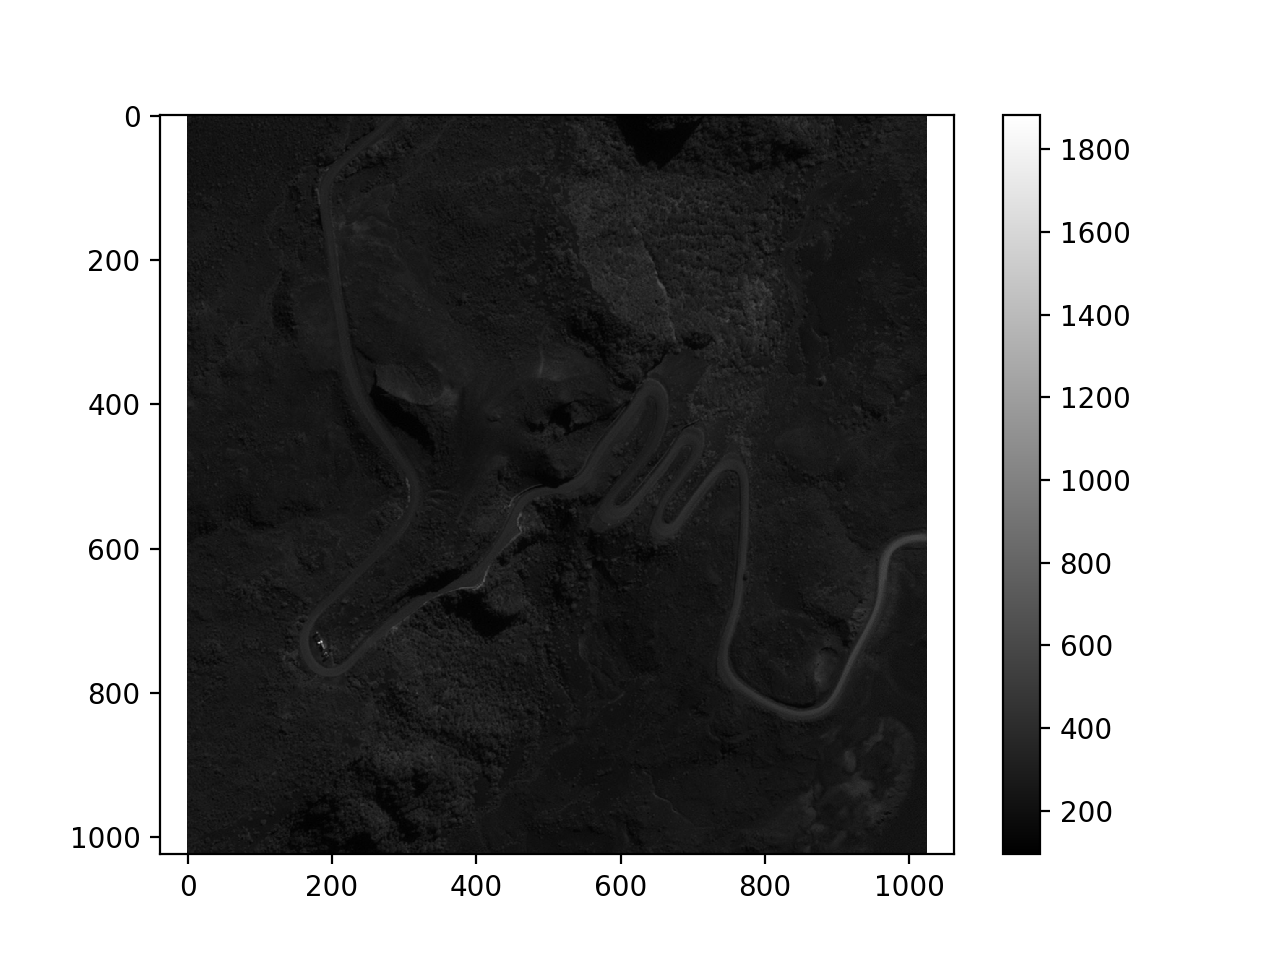

In [2]:
filename_1 = '../testdata/input_pair/img_01.tif'
a = readGTIFF(filename_1)
display_imshow(a)

<IPython.core.display.Javascript object>


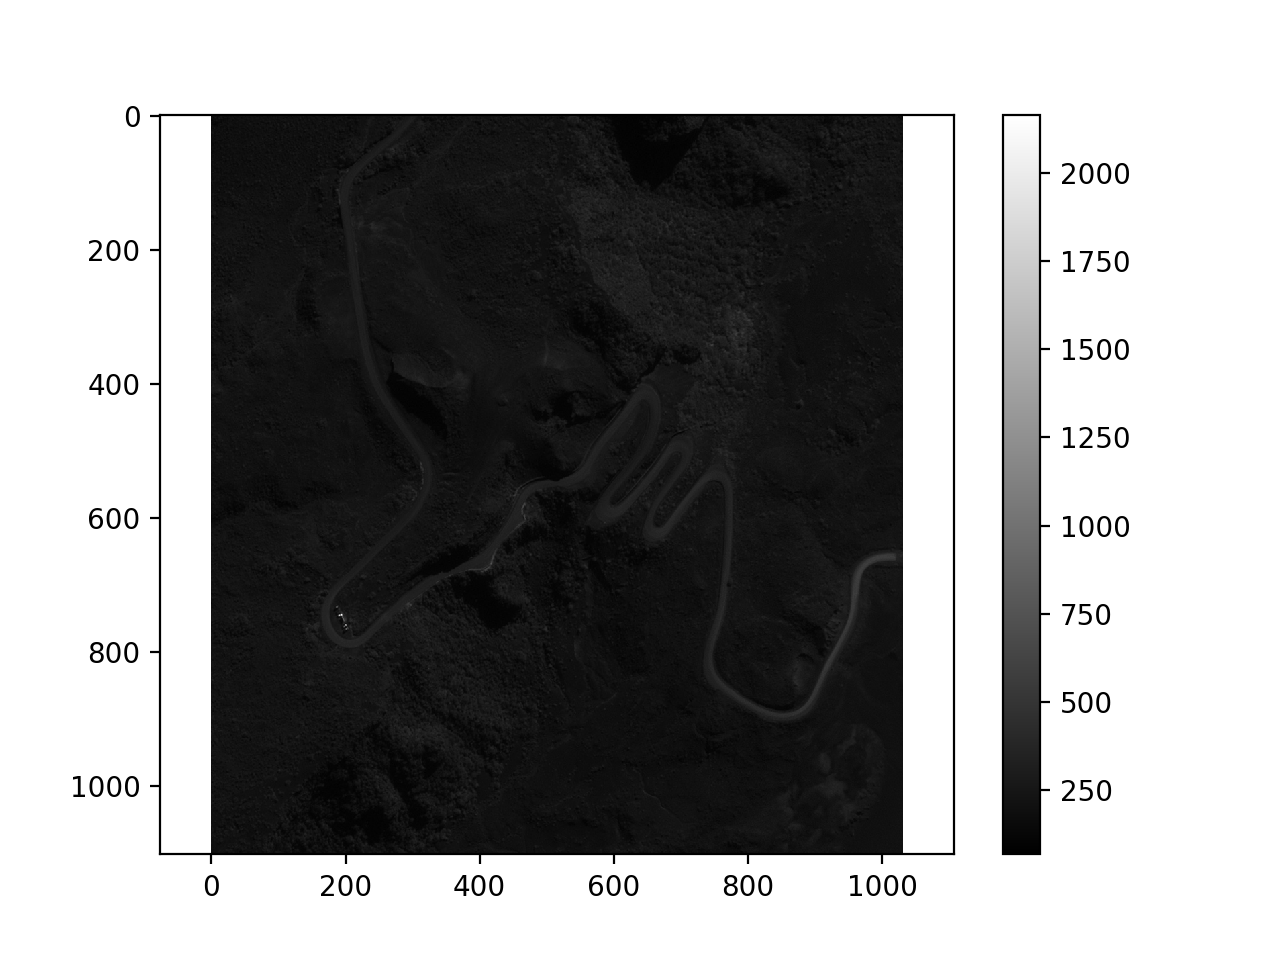

In [3]:
filename_2 = '../testdata/input_pair/img_02.tif'
a = readGTIFF(filename_2)
display_imshow(a)

<IPython.core.display.Javascript object>


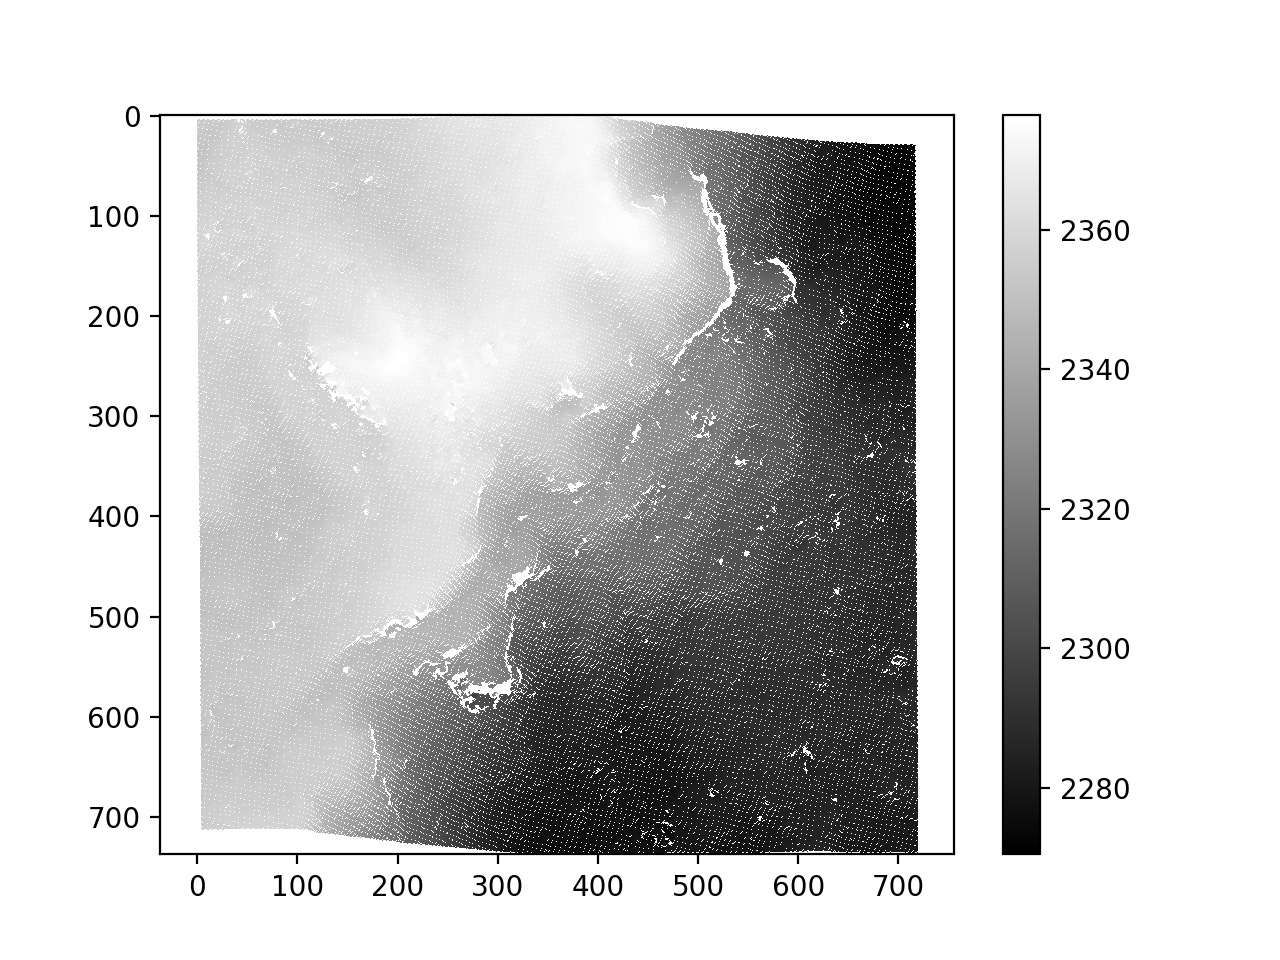

In [4]:
output = '../testoutput/output_pair/dsm.tif'
a = readGTIFF(output)
display_imshow(a)

<IPython.core.display.Javascript object>


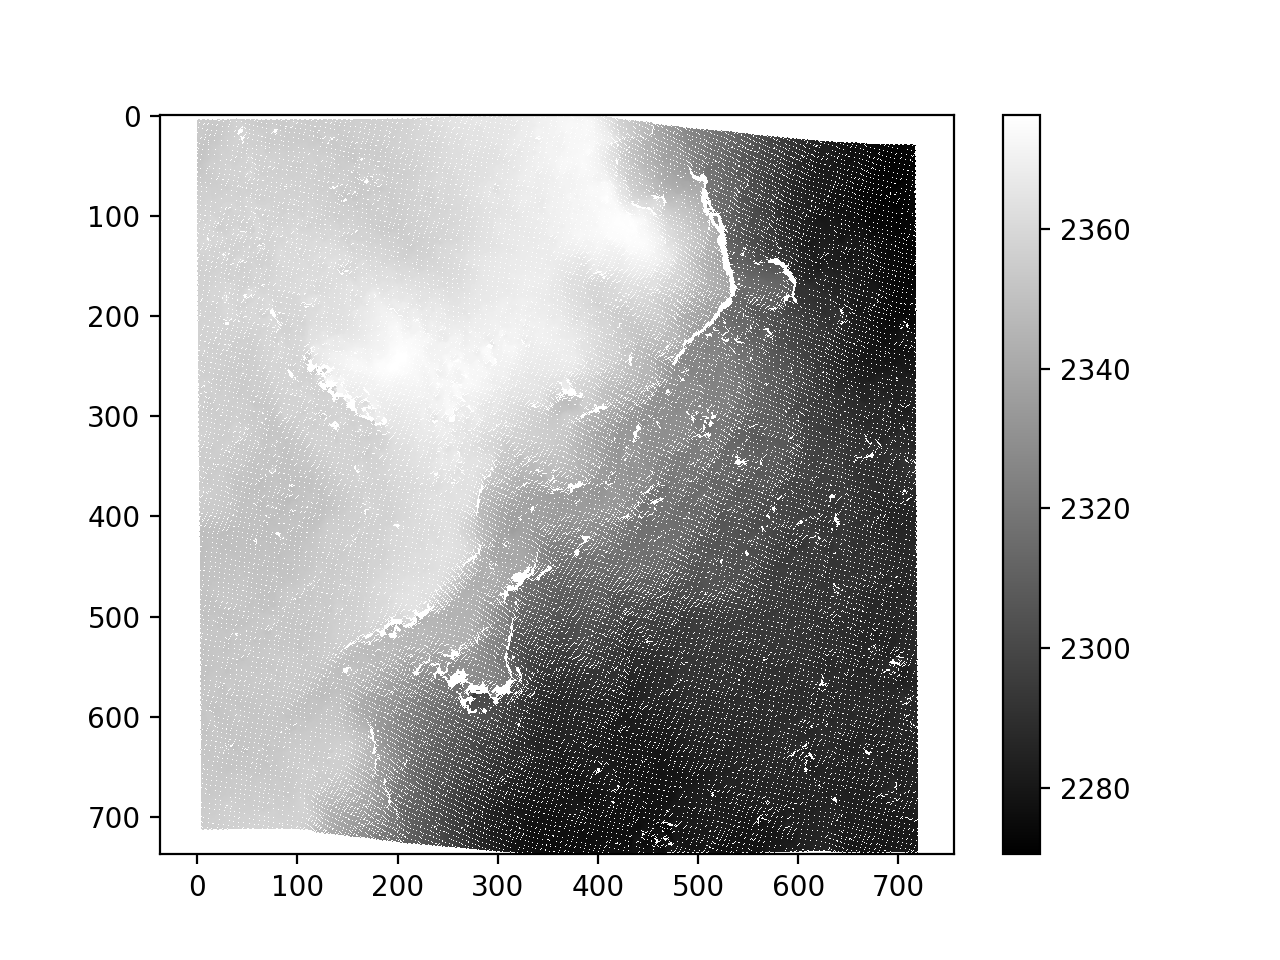

In [5]:
expected_output = '../testdata/expected_output/pair/dsm.tif'
a = readGTIFF(expected_output)
display_imshow(a)

# Data from Planet


In [6]:
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''
    import numpy as np
    mi, ma = np.nanpercentile(im.flatten(), (percentiles,100-percentiles))
    im = np.minimum(np.maximum(im,mi), ma) # clip
    im = (im-mi)/(ma-mi)*255.0   # scale
    im=im.astype(np.uint8)
    return im

In [7]:
import os
import copy
from ipytools import readGTIFF, writeGTIFF, readGTIFFmeta, display_gallery

In [70]:
def get_files(folder):
    """  Get all TIFF in the folder """
    tiff_dict = {1: [], 2:[], 3:[]}
    for dirname, dirnames, filenames in os.walk(folder):
        # print path to all filenames.
        for filename in filenames:
            if  filename.endswith('.tif'):
                complete_filename = os.path.join(dirname, filename)
                d = int(filename.split('_')[3][1])
                tiff_dict[d].append(complete_filename)
    for key in tiff_dict:
        tiff_dict[key] = sorted(tiff_dict[key])
    return tiff_dict

In [71]:
def retrieve_triplets():
    folders = {'1107':[], '1148':[], '1231':[]}
    min_len = float('inf')
    for f in folders:
        folder = '../data/s03_20161003T16' + f + 'Z/panchromatic/'
        folders[f] = get_files(folder)
    return folders

In [72]:
def display_triplets(d, i, folders, roi=None):
    l = []
    g = []
    for f in folders:
        im_name = folders[f][d][i-1]
        g.append(im_name)
        im = readGTIFF(im_name)
        if (roi != None):
            x, y, w, h = roi["x"], roi["y"], roi["w"], roi["h"]
            im = im[y:y+h, x:x+w]
        print('Dimension: ', im.shape)
        l.append(simple_equalization_8bit(im))
    display_gallery(l, g)

In [73]:
folders = retrieve_triplets()

In [80]:
d = 2
i = 9

Dimension:  (1349, 3199, 1)
Dimension:  (1349, 3199, 1)
Dimension:  (1349, 3199, 1)



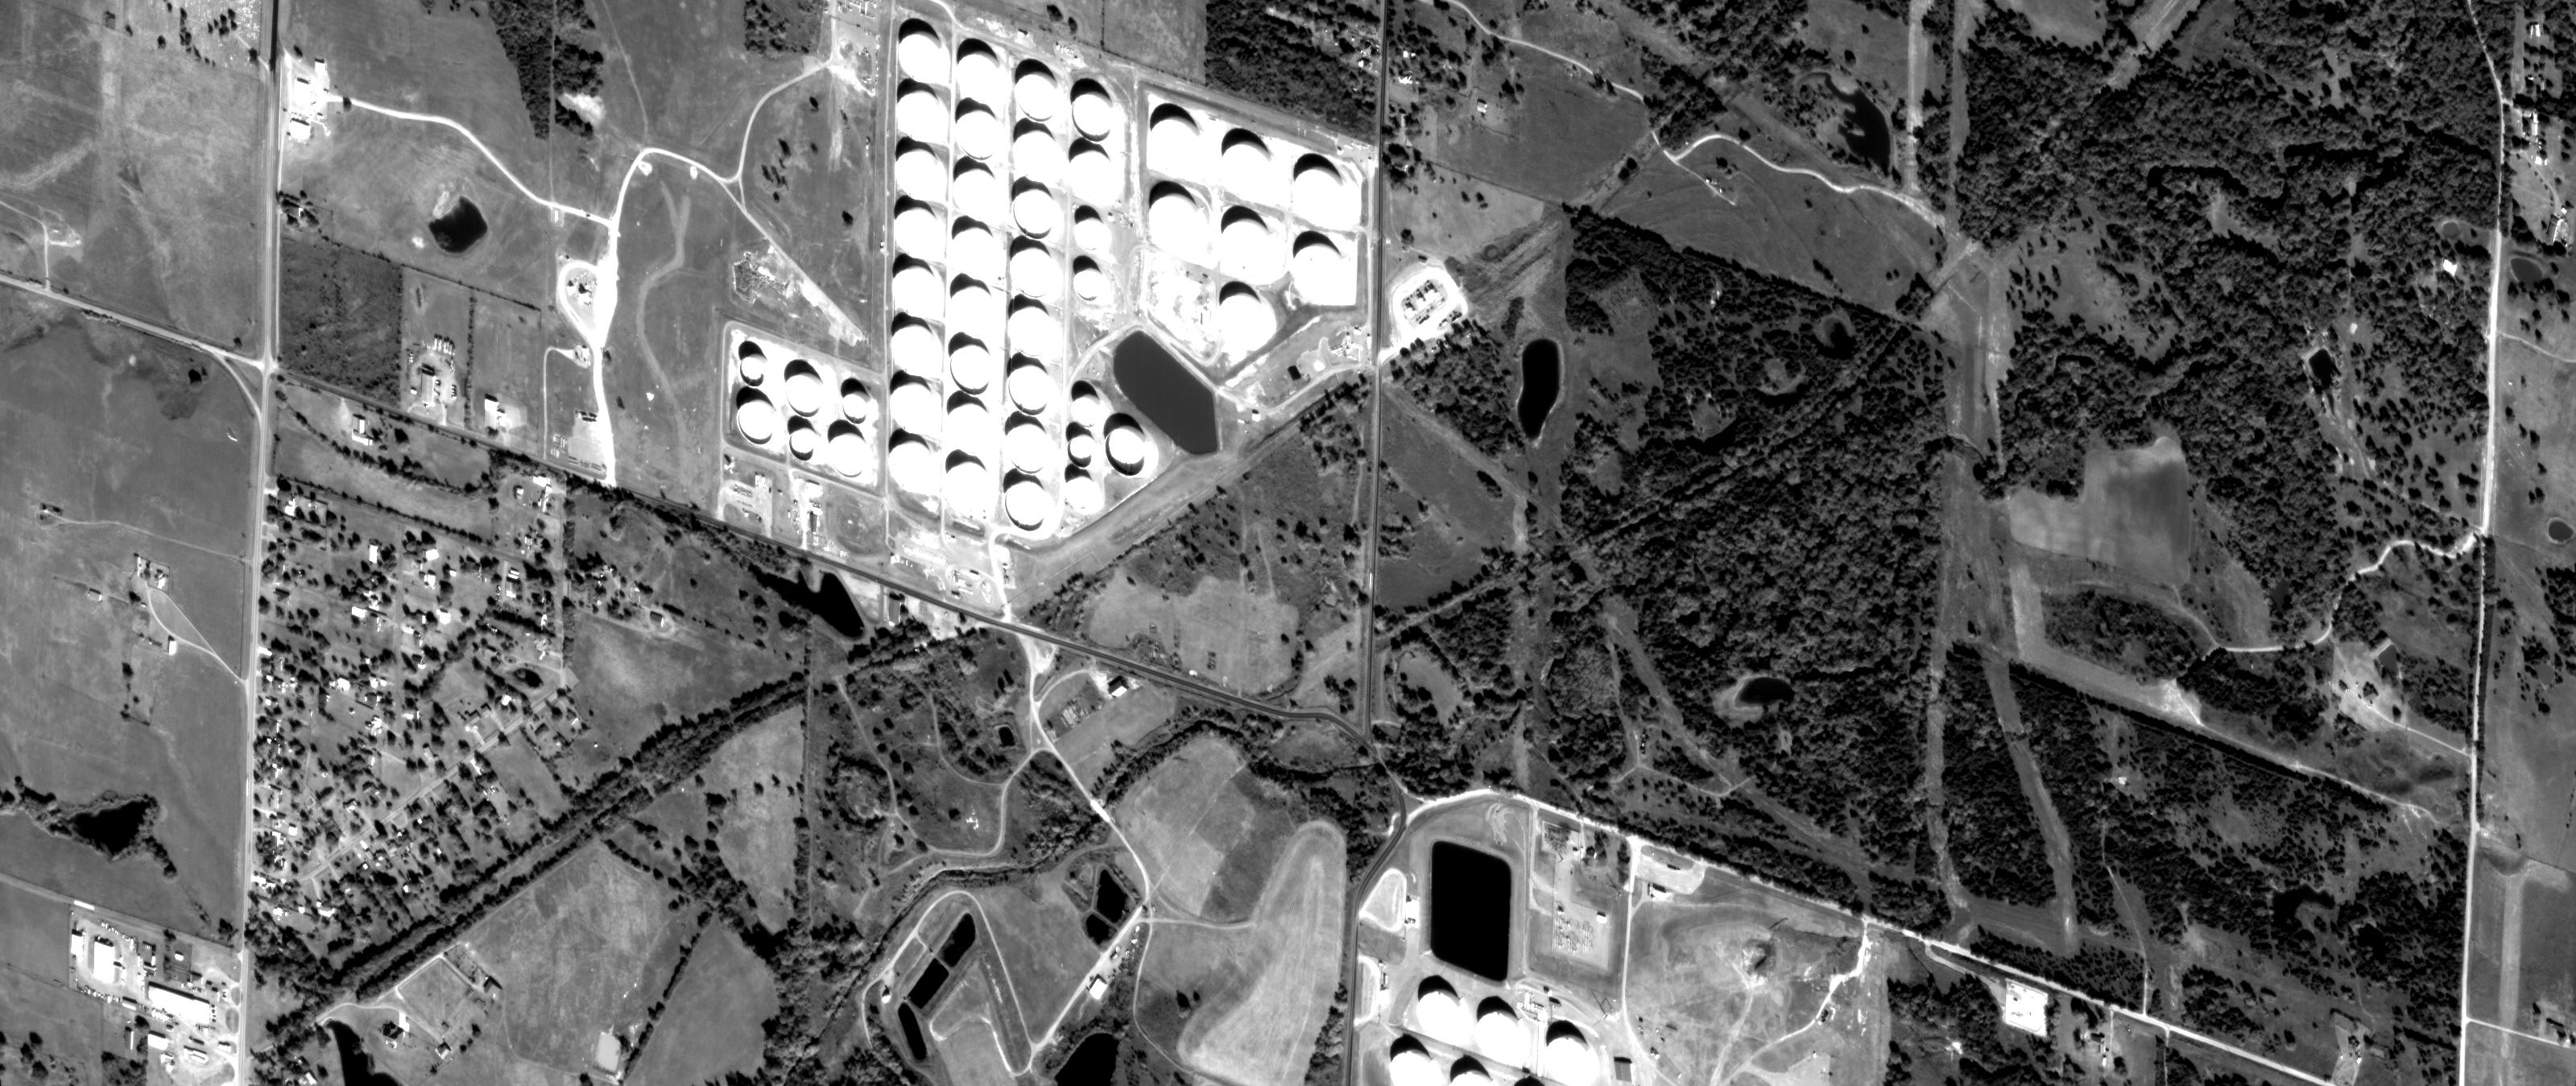
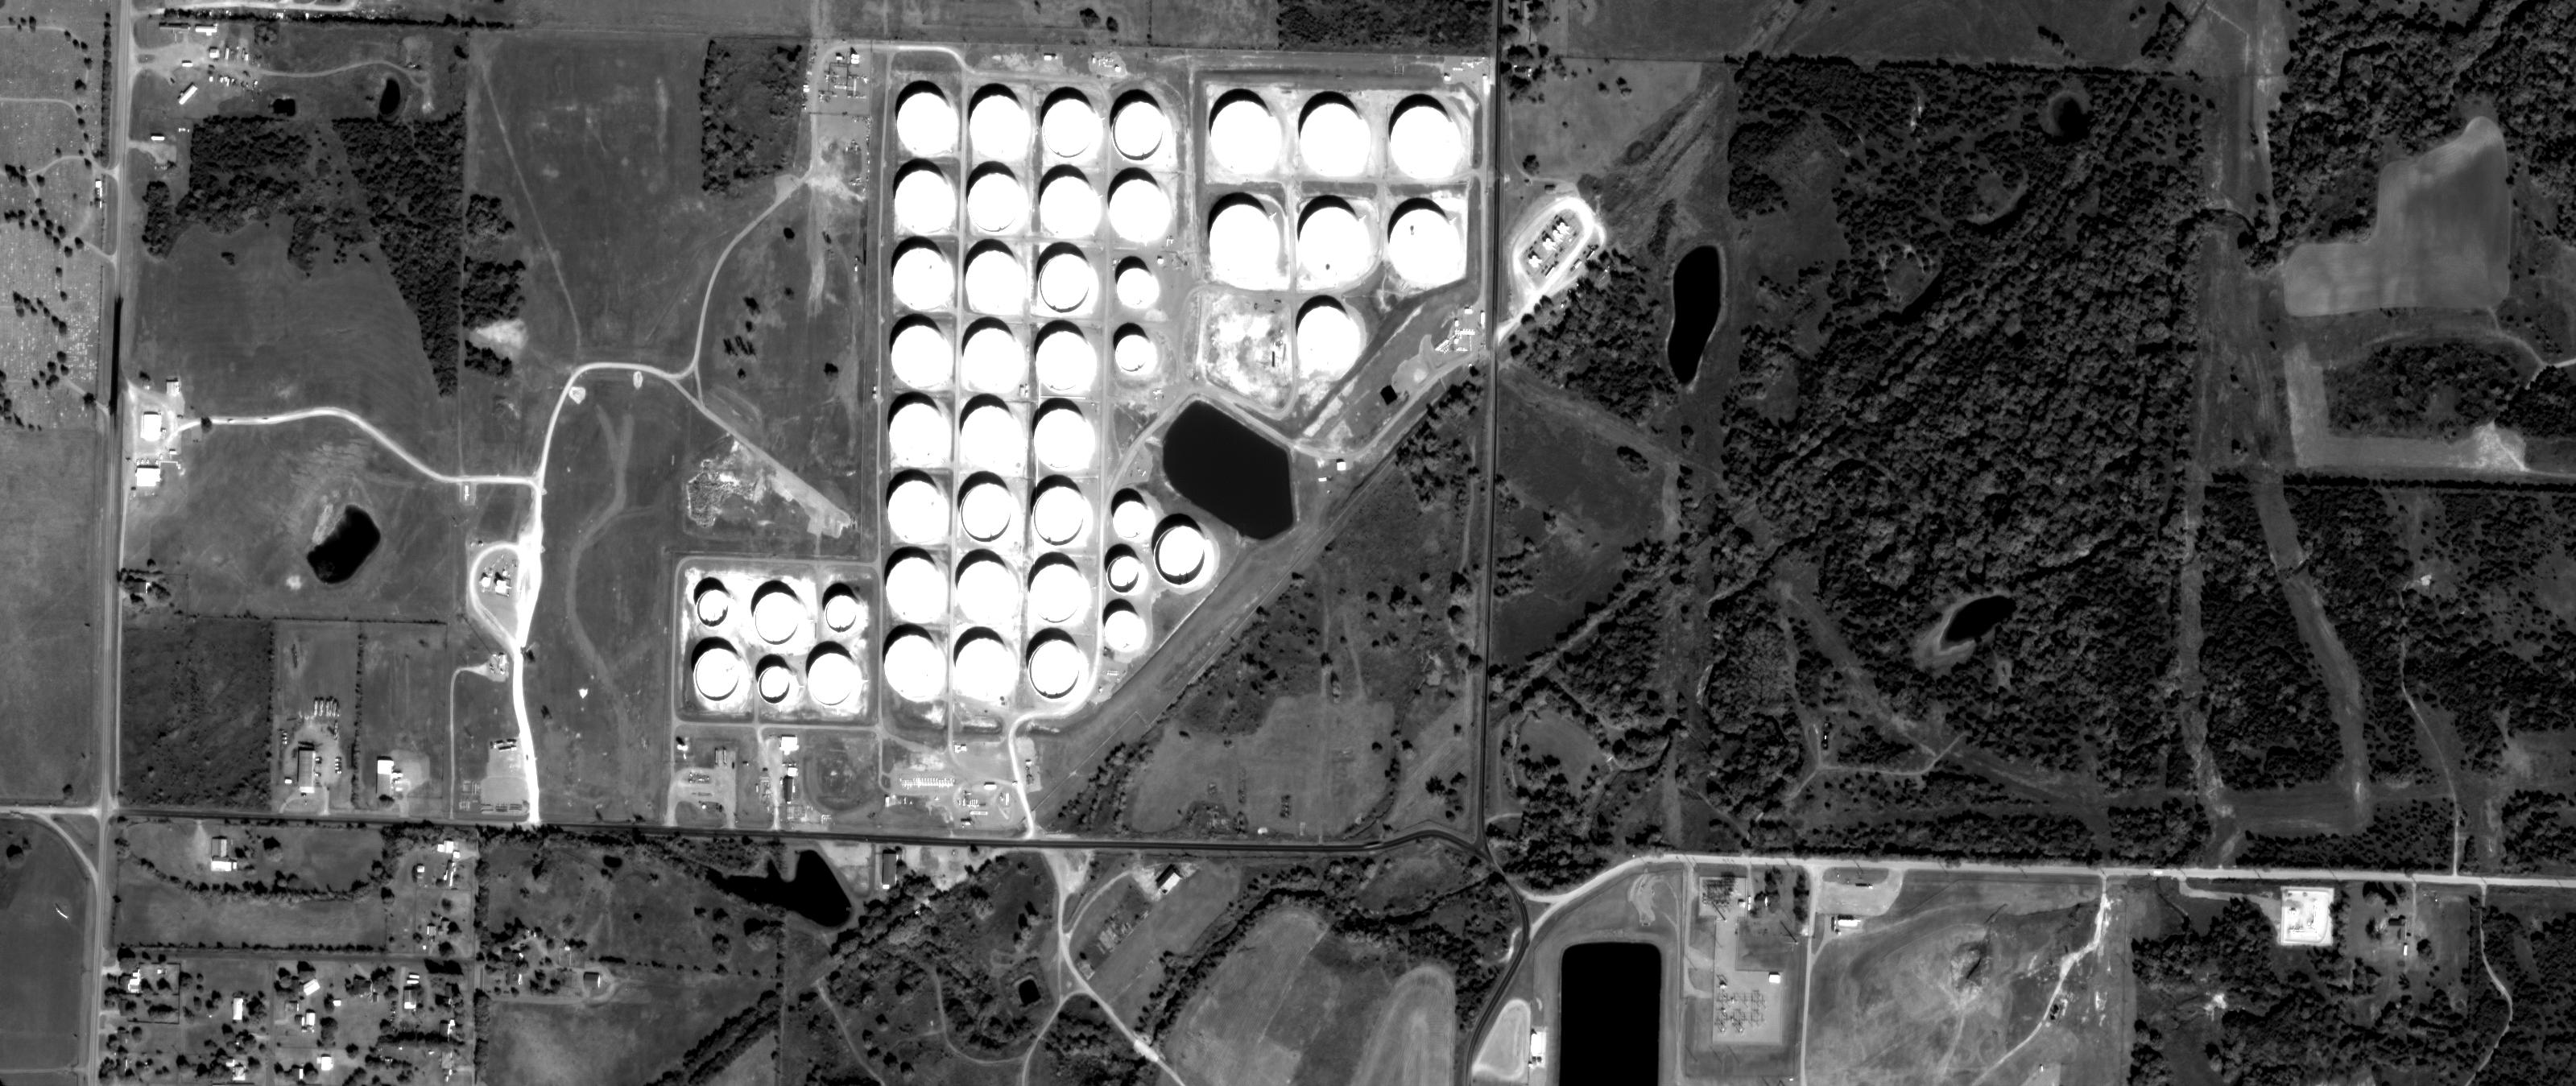
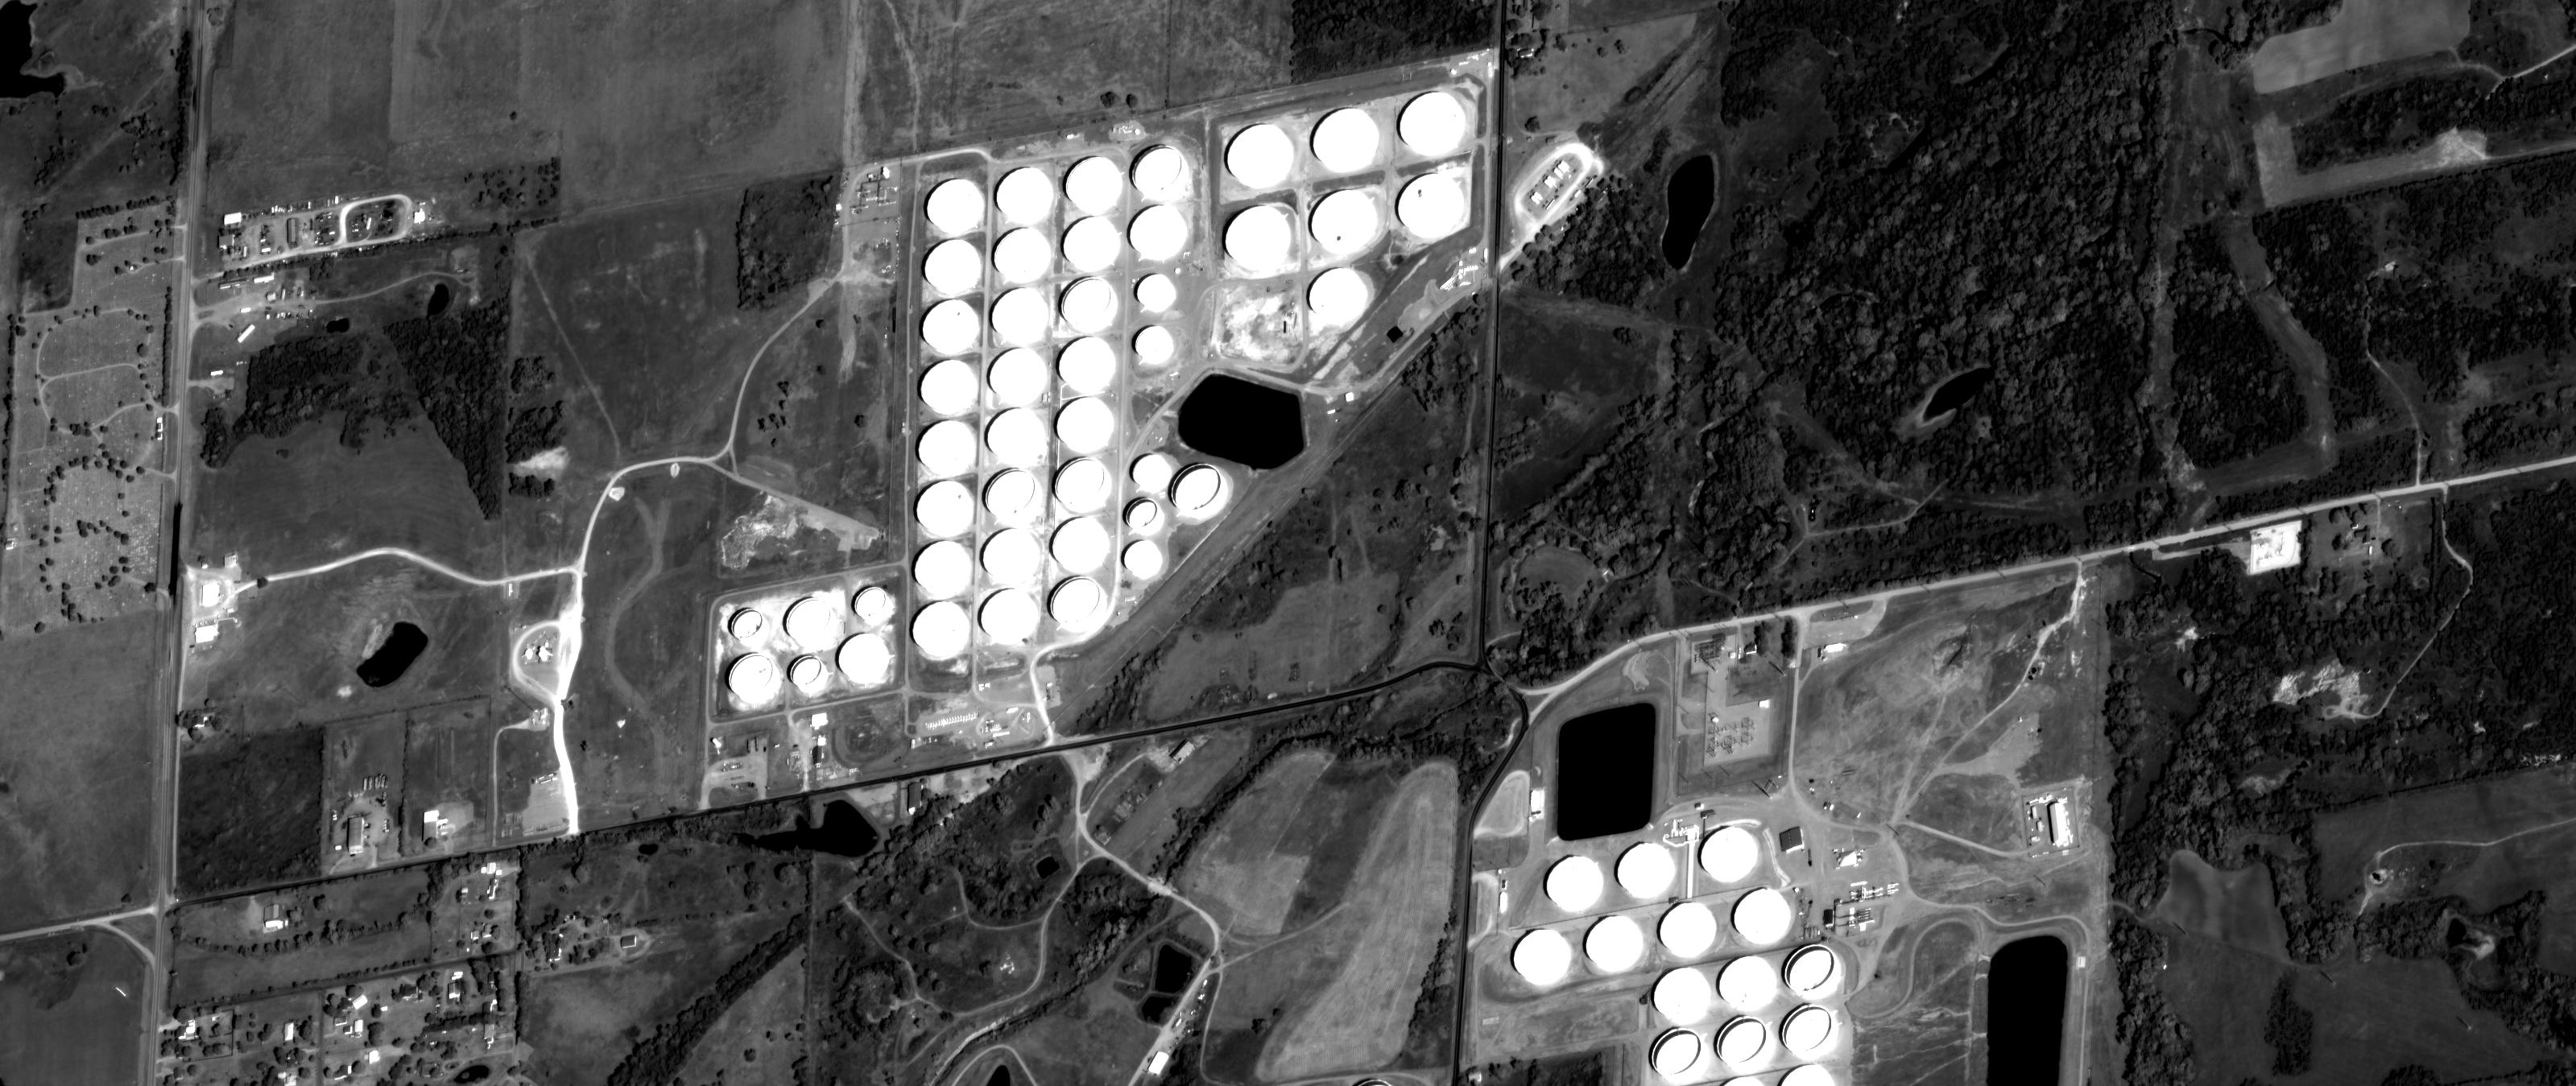

In [114]:
display_triplets(d, i, folders) #roi)

In [155]:
roi = {
    "x": 1000,
    "y": 0,
    "w": 1000,
    "h": 1000
  }

Dimension:  (1000, 1000, 1)
Dimension:  (1000, 1000, 1)
Dimension:  (1000, 1000, 1)



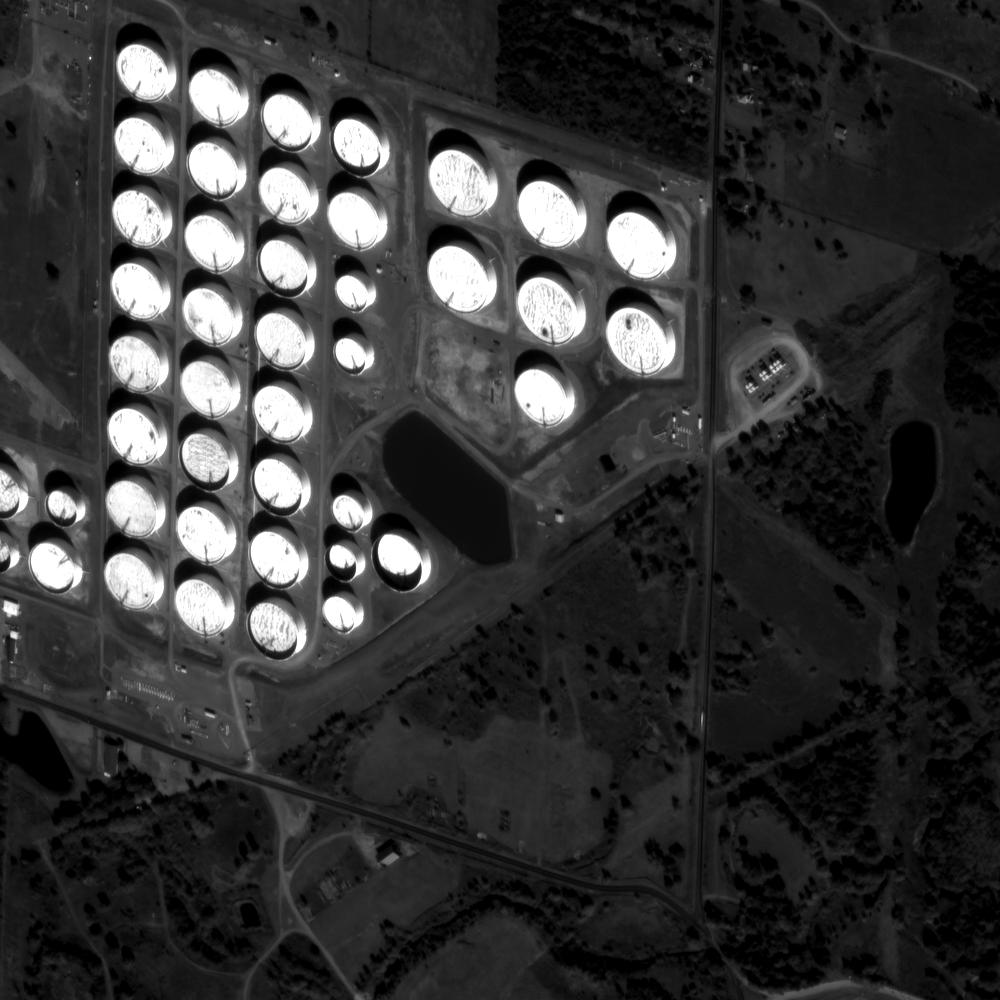
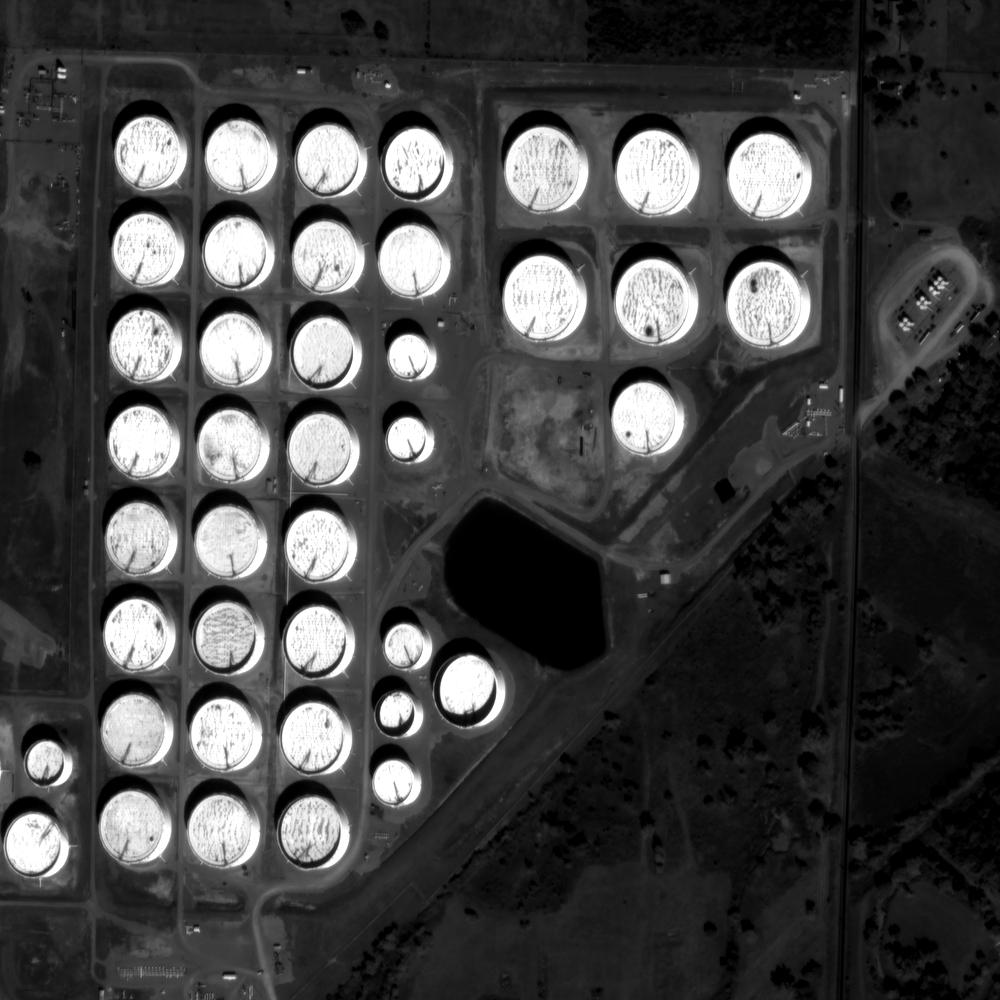
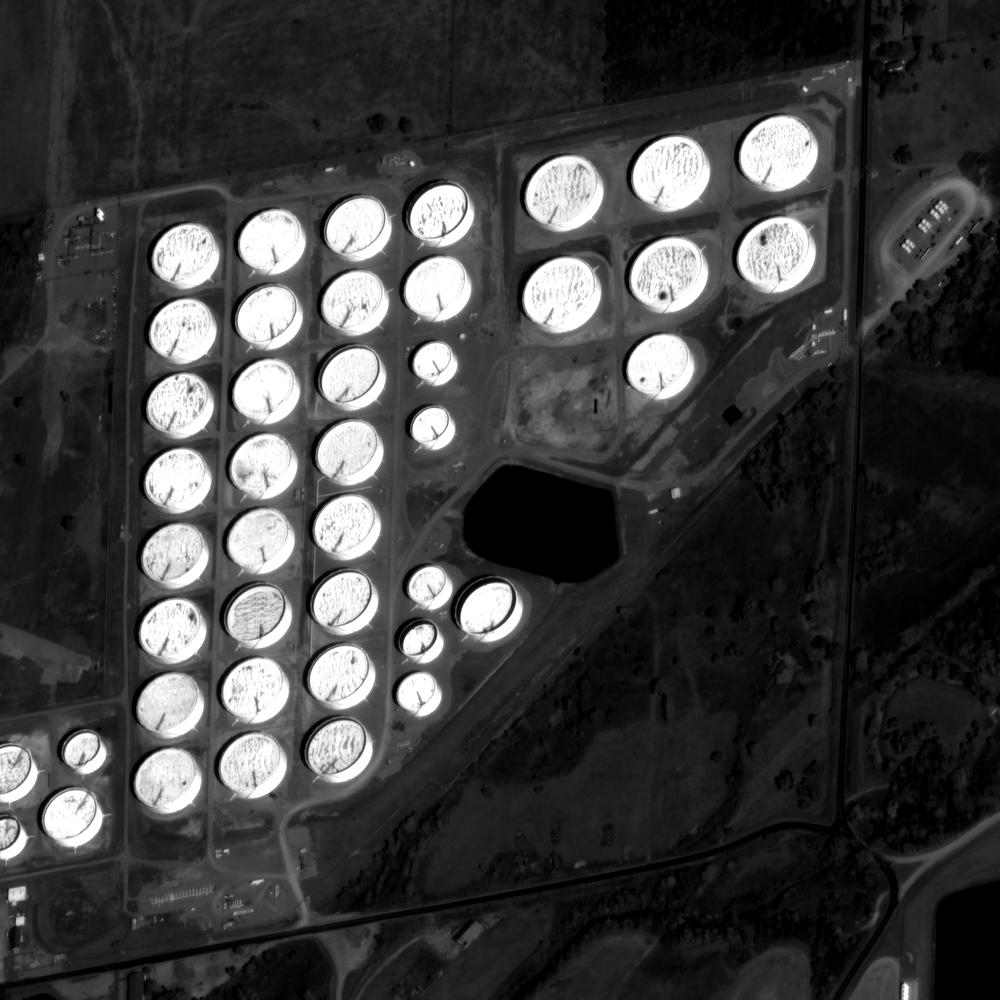

In [156]:
display_triplets(d, i, folders, roi)

In [157]:
def workaround_json_int64(o):
    if isinstance(o,np.integer) : return int(o)
    raise TypeError

In [189]:
import json
def write_json(d, i, folders, indices, roi=None):
    # Get current config file
    with open('config.json', 'r') as f:
        user_cfg = json.load(f)
    user_cfg['out_dir'] = './output'
    # Config path of images and RPC
    images = []
    for j in indices:
        img_dict = {}
        img_name = folders[j][d][i]
        img_dict['img'] = img_name
        img_dict['rpc'] = '..' + img_name.split('.')[2] + '_rpc.txt'
        images.append(img_dict)
    user_cfg['images'] = images
    # Tile size
    user_cfg["tile_size"] = 1000
    # Config ROI 
    if (roi == None):
        user_cfg["full_img"] = True
    else:
        user_cfg["full_img"] = False
        user_cfg["roi"] = roi
    # Modify config file   
    with open('config.json', 'w') as f:
        json.dump(user_cfg, f, indent=2, default=workaround_json_int64)

In [197]:
write_json(d, i, folders, ['1148' , '1231'], roi)

In [198]:
!rm -rf output

In [199]:
!cd .. && python3 s2p.py yaw_extension/config.json

out_dir is: /Users/juleskozolinsky/Projets/s2p/yaw_extension/./output
tile size: 1000 1000
total number of tiles: 1 (1 x 1)

discarding masked tiles...
done 1 / 1 tiles
Elapsed time: 0:00:00.130553

correcting pointing locally...
correcting pointing on tile 1000 0 pair 1...

RUN: sift_roi /Users/juleskozolinsky/Projets/s2p/data/s03_20161003T161148Z/panchromatic/s03_20161003T161148Z_pan_d2_0010.tif 1000 0 1000 1000 --thresh-dog 0.013300 -o /tmp/s2p_6_gyd3js.txt
0:00:02.009276

RUN: sift_roi /Users/juleskozolinsky/Projets/s2p/data/s03_20161003T161231Z/panchromatic/s03_20161003T161231Z_pan_d2_0010.tif 1015 -315 982 1061 --thresh-dog 0.013300 -o /tmp/s2p_a4e9zxsz.txt
0:00:01.485604

RUN: matching /tmp/s2p_6_gyd3js.txt /tmp/s2p_a4e9zxsz.txt -relative 0.600000 -o /tmp/s2p_toysbr2w.txt -f "0.7230727061967979 0.16394041951155044 -0.6595989129455293 -0.12336399168595251 -73.54078444370583"
46 matches
0:00:01.808746

RUN: ransac fmn 1000 .3 7 /tmp/s2p_toysbr2w.txt < /tmp/s2p_toysbr2w.txt
pmean =

In [174]:
def get_rectified_images():
    dict_name_images = {}
    for dirname, dirnames, filenames in os.walk('./output/tiles'):
        if (dirname.split('/')[-1] == 'pair_1'):
            # Init dict 
            dict_name_images[dirname] = []
            for filename in filenames:
                complete_filename = os.path.join(dirname, filename)
                # Depending on succes or not
                if (filename == 'stderr.log'):
                    print("NOT MATCHES in "+complete_filename)
                if (filename == 'rectified_ref.tif' or filename == 'rectified_sec.tif'):
                    dict_name_images[dirname].append(filename)
    return dict_name_images

In [175]:
dict_name_images = get_rectified_images()
print(dict_name_images)

{'./output/tiles/row_0000000_height_1000/col_0001000_width_1000/pair_1': ['rectified_ref.tif', 'rectified_sec.tif']}



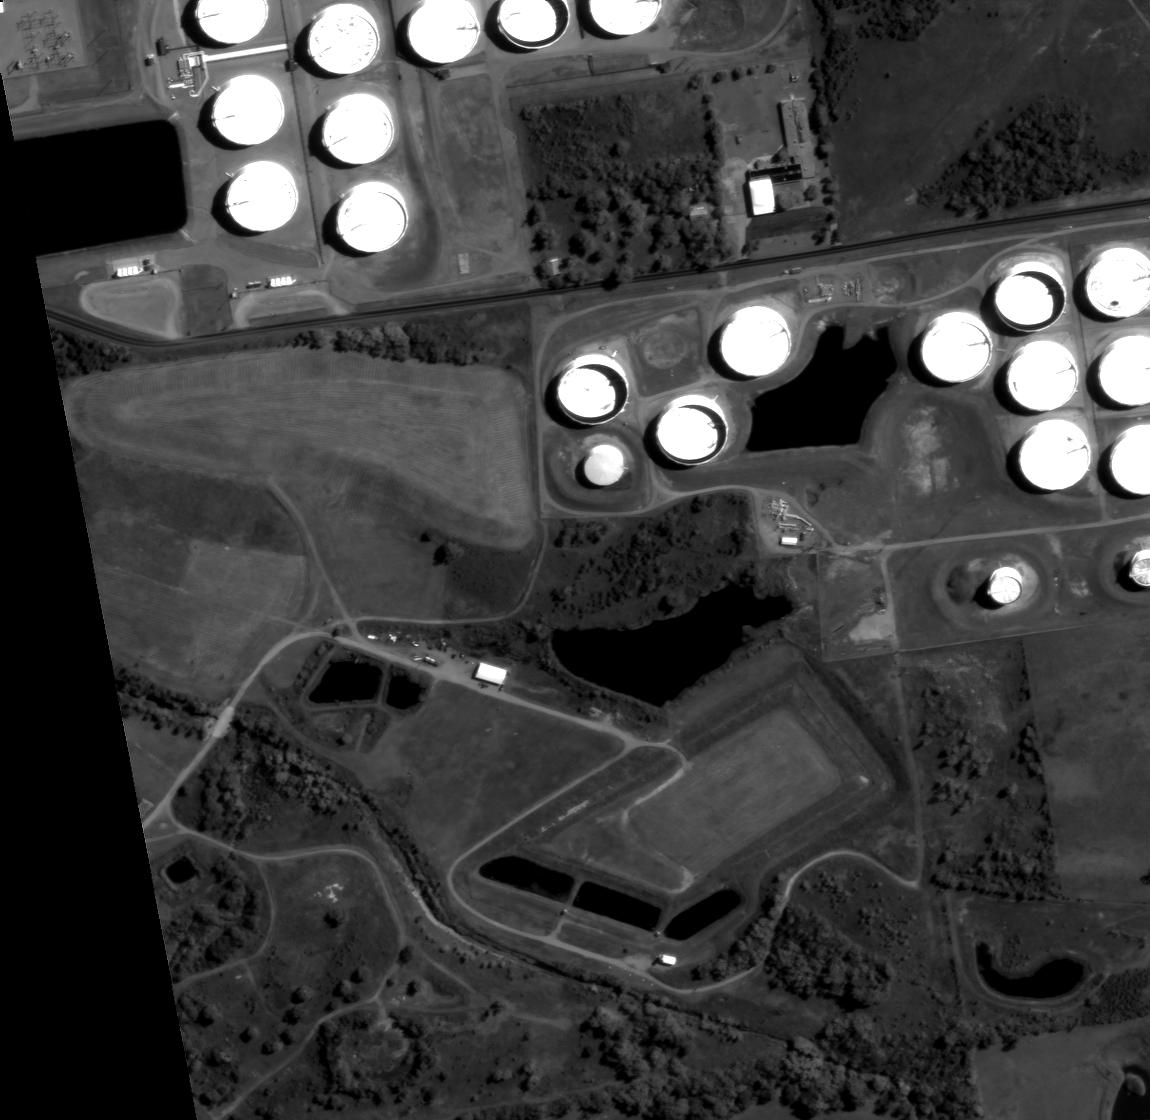
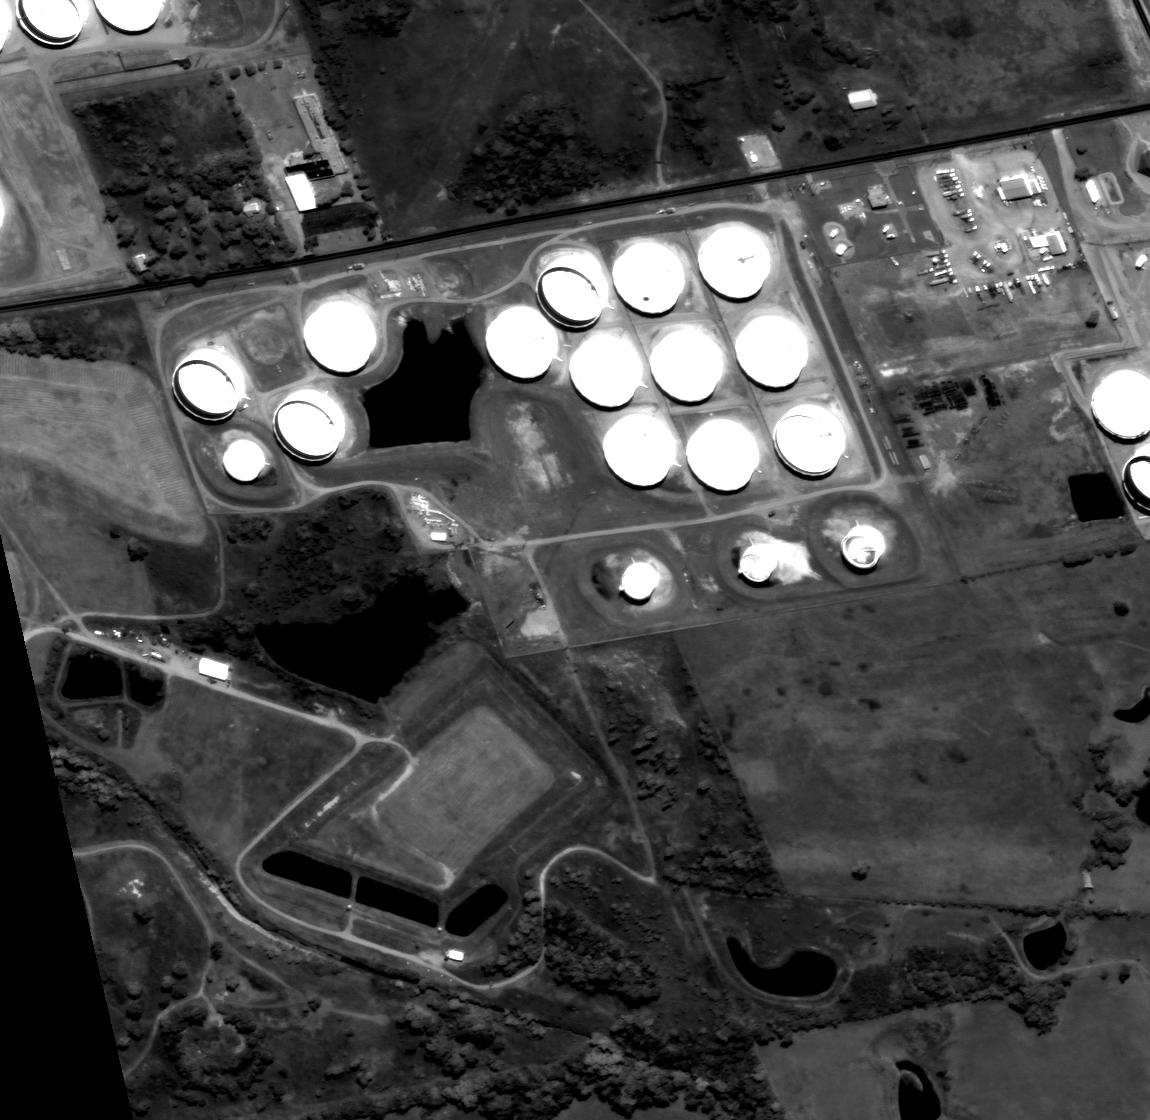

In [176]:
key = 0
for key in dict_name_images:
    a_ref = key + '/' + dict_name_images[key][0]
    a_sec = key + '/' + dict_name_images[key][1]
    display_gallery([simple_equalization_8bit(readGTIFF(a_ref)), simple_equalization_8bit(readGTIFF(a_sec))])

In [106]:
expected_output = './output/s03_20161003T161107Z/dsm.tif'
a = readGTIFF(expected_output)

RasterioIOError: ./output/s03_20161003T161107Z/dsm.tif: No such file or directory

<IPython.core.display.Javascript object>


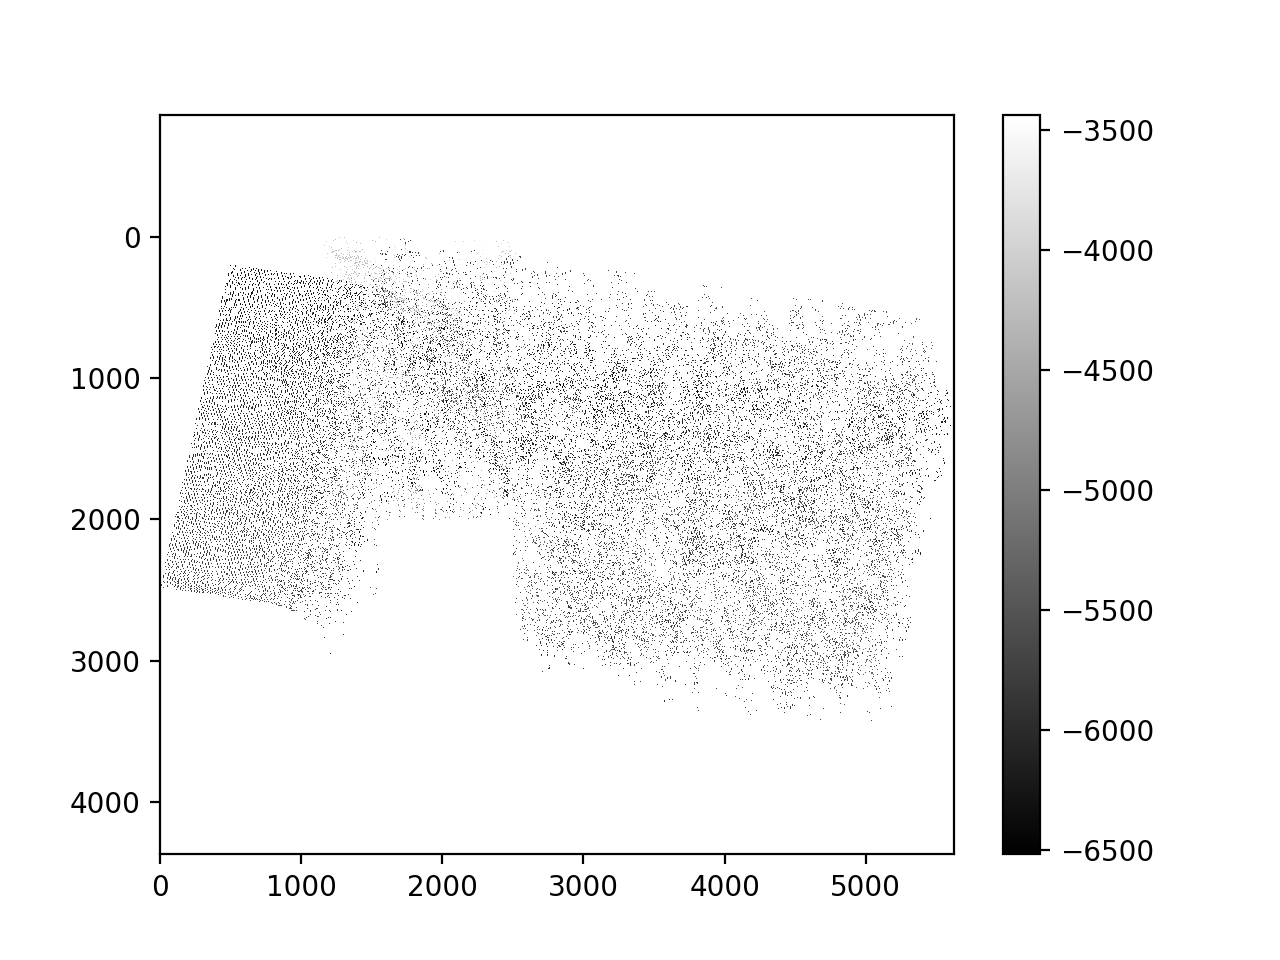

In [18]:
b = a#readGTIFF('/Users/juleskozolinsky/Projets/s2p/yaw_extension/output/s03_20161003T161107Z/tiles/row_0000000_height_500/col_0001000_width_500/dsm.tif')
display_imshow(b)